In [17]:
import pandas as pd
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr


# Data Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Machine Learning Model
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [18]:

# Load the dataset
file_path = './data/Data Insights - Synthetic Dataset.xlsx'
df = pd.read_excel(file_path, sheet_name='Data Insights - Synthetic Datas')

In [19]:
# Function to convert object columns to float
def convert_to_float(df, columns):
    for col in columns:
        try:
            # Attempt to convert the column to float
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f"Successfully converted {col} to float.")
        except Exception as e:
            print(f"Error converting {col}: {e}")
    return df


charge_columns = ['AccommodationCharge', 'CCU_Charges', 'ICU_Charge', 'TheatreCharge', 'PharmacyCharge', 'ProsthesisCharge', 'OtherCharges', 'BundledCharges']

In [20]:

df = convert_to_float(df, charge_columns)

Successfully converted AccommodationCharge to float.
Successfully converted CCU_Charges to float.
Successfully converted ICU_Charge to float.
Successfully converted TheatreCharge to float.
Successfully converted PharmacyCharge to float.
Successfully converted ProsthesisCharge to float.
Successfully converted OtherCharges to float.
Successfully converted BundledCharges to float.


In [21]:
# Fill NaN values in the charge columns with 0
df[charge_columns] = df[charge_columns].fillna(0)

### 2. Create Features from the Data Set

#### 2.1 Create Length of Stay Column

In [22]:
# Function to calculate the Length of Stay (LOS)
def calculate_length_of_stay(df, admission_col, separation_col):
    # Convert admission and separation dates to datetime format
    df[admission_col] = pd.to_datetime(df[admission_col], errors='coerce')
    df[separation_col] = pd.to_datetime(df[separation_col], errors='coerce')
    
    # Calculate the difference in days between SeparationDate and AdmissionDate
    df['LengthOfStay'] = (df[separation_col] - df[admission_col]).dt.days
    
    # Handle cases where LOS is negative or missing (e.g., errors in dates)
    df['LengthOfStay'] = df['LengthOfStay'].apply(lambda x: x if x >= 0 else None)
    
    return df

# Applying the function
df = calculate_length_of_stay(df, 'AdmissionDate', 'SeparationDate')


#### 2.2 Create Total Charges Column

In [23]:
# Calculate Total Charge without PharmacyCharge
df['TotalCharges'] = df[['AccommodationCharge', 'TheatreCharge', 
                         'ProsthesisCharge', 'OtherCharges', 
                         'BundledCharges', 'CCU_Charges', 'ICU_Charge']].sum(axis=1, skipna=True)

In [24]:
#### 2.3 Map Diagnosis Codes to Categories
# Define ICD-10 chapters with their corresponding code ranges
icd10_chapters = [
    ('A00', 'B99', 'Certain infectious and parasitic diseases'),
    ('C00', 'D48', 'Neoplasms'),
    ('D50', 'D89', 'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism'),
    ('E00', 'E89', 'Endocrine, nutritional and metabolic diseases'),
    ('F00', 'F99', 'Mental and behavioural disorders'),
    ('G00', 'G99', 'Diseases of the nervous system'),
    ('H00', 'H59', 'Diseases of the eye and adnexa'),
    ('H60', 'H95', 'Diseases of the ear and mastoid process'),
    ('I00', 'I99', 'Diseases of the circulatory system'),
    ('J00', 'J99', 'Diseases of the respiratory system'),
    ('K00', 'K95', 'Diseases of the digestive system'),
    ('L00', 'L99', 'Diseases of the skin and subcutaneous tissue'),
    ('M00', 'M99', 'Diseases of the musculoskeletal system and connective tissue'),
    ('N00', 'N99', 'Diseases of the genitourinary system'),
    ('O00', 'O99', 'Pregnancy, childbirth and the puerperium'),
    ('P00', 'P96', 'Certain conditions originating in the perinatal period'),
    ('Q00', 'Q99', 'Congenital malformations, deformations and chromosomal abnormalities'),
    ('R00', 'R99', 'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified'),
    ('S00', 'T98', 'Injury, poisoning and certain other consequences of external causes'),
    ('U00', 'U99', 'Codes for special purposes'),
    ('V00', 'Y99', 'External causes of morbidity and mortality'),
    ('Z00', 'Z99', 'Factors influencing health status and contact with health services')
]

def map_icd10_to_chapter(code: str) -> str:
    """
    Maps an ICD-10 diagnosis code to its corresponding chapter.
    """
    code = code.upper().strip()
    if len(code) < 3:
        code_prefix = code.ljust(3, '0')
    else:
        code_prefix = code[:3]
    
    for start, end, chapter in icd10_chapters:
        if start <= code_prefix <= end:
            return chapter
    return 'Unknown'

def add_icd10_chapters(df: pd.DataFrame, diagnosis_cols: list) -> pd.DataFrame:
    """
    Adds ICD-10 chapter mappings to the DataFrame for specified diagnosis columns.
    """
    for diag_col in diagnosis_cols:
        chapter_col = diag_col + '_Chapter'
        df[chapter_col] = df[diag_col].apply(map_icd10_to_chapter)
    return df

In [25]:
# Add ICD-10 Chapters
df = add_icd10_chapters(df, ['PrincipalDiagnosis'])

In [26]:
# Visualization (Optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


## 3. Functions for Model Development

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')


# Utility Functions

def preprocess_data(numerical_cols, categorical_cols):
    """
    Creates a preprocessing pipeline for numerical and categorical data.
    
    Parameters:
    - numerical_cols (list): List of numerical column names.
    - categorical_cols (list): List of categorical column names.
    
    Returns:
    - preprocessor (ColumnTransformer): Preprocessing pipeline.
    """
    # Numerical preprocessing pipeline
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Categorical preprocessing pipeline
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    return preprocessor

def create_model_pipeline(preprocessor, model_type='RandomForest'):
    """
    Creates a machine learning pipeline with preprocessing and regression model.
    
    Parameters:
    - preprocessor (ColumnTransformer): Preprocessing pipeline.
    - model_type (str): Type of regression model ('RandomForest', 'GradientBoosting', 'LinearRegression', 'XGBoost').
    
    Returns:
    - model (Pipeline): Complete machine learning pipeline.
    """
    if model_type == 'RandomForest':
        regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'GradientBoosting':
        regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
    elif model_type == 'LinearRegression':
        regressor = LinearRegression()
    elif model_type == 'XGBoost':
        regressor = xgb.XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
    else:
        raise ValueError("Unsupported model_type. Choose from 'RandomForest', 'GradientBoosting', 'LinearRegression', 'XGBoost'.")

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    return model

def cross_validate_model(model, X, y, n_splits=5):
    """
    Performs cross-validation and returns evaluation metrics.
    
    Parameters:
    - model (Pipeline): Machine learning pipeline.
    - X (pd.DataFrame): Feature set.
    - y (pd.Series): Target variable.
    - n_splits (int): Number of cross-validation folds.
    
    Returns:
    - cv_metrics (dict): Dictionary containing cross-validation metrics.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

    cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)

    # Convert negative metrics to positive
    cv_metrics = {
        'MAE': -cv_results['test_neg_mean_absolute_error'].mean(),
        'MSE': -cv_results['test_neg_mean_squared_error'].mean(),
        'R2': cv_results['test_r2'].mean()
    }

    print("\nCross-Validation Metrics:")
    for metric, value in cv_metrics.items():
        print(f"{metric}: {value:.4f}")

    return cv_metrics

def train_and_test_model(model, X, y, test_size=0.2):
    """
    Splits the data, trains the model, and evaluates it on the test set.
    
    Parameters:
    - model (Pipeline): Machine learning pipeline.
    - X (pd.DataFrame): Feature set.
    - y (pd.Series): Target variable.
    - test_size (float): Proportion of the dataset to include in the test split.
    
    Returns:
    - test_metrics (dict): Dictionary containing test set evaluation metrics.
    - y_pred (np.ndarray): Predicted values on the test set.
    - y_test (pd.Series): Actual target values on the test set.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    test_metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

    print("\nTest Set Evaluation:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")

    return test_metrics, y_pred, y_test

def compile_performance_metrics(cv_metrics, test_metrics, model_name):
    """
    Compiles cross-validation and test metrics into a DataFrame.
    
    Parameters:
    - cv_metrics (dict): Cross-validation metrics.
    - test_metrics (dict): Test set evaluation metrics.
    - model_name (str): Name of the model.
    
    Returns:
    - metrics_df (pd.DataFrame): DataFrame containing the metrics.
    """
    metrics_df = pd.DataFrame({
        'Model': [model_name],
        'CV_MAE': [cv_metrics['MAE']],
        'CV_MSE': [cv_metrics['MSE']],
        'CV_R2': [cv_metrics['R2']],
        'Test_MAE': [test_metrics['MAE']],
        'Test_RMSE': [test_metrics['RMSE']],
        'Test_R2': [test_metrics['R2']]
    })
    return metrics_df

def plot_model_performance(performance_df):
    """
    Plots a bar chart comparing the performance of different models.
    
    Parameters:
    - performance_df (pd.DataFrame): DataFrame containing performance metrics for each model.
    """
    metrics = ['CV_MAE', 'CV_MSE', 'CV_R2', 'Test_MAE', 'Test_RMSE', 'Test_R2']
    plt.figure(figsize=(18, 12))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 3, i)
        sns.barplot(x='Model', y=metric, data=performance_df, palette='viridis')
        plt.title(f'Comparison of {metric}')
        plt.xlabel('Model')
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.tight_layout()
    
    plt.suptitle('Model Performance Comparison', fontsize=20, y=1.05)
    plt.show()



In [56]:
def build_and_compare_models(
    df: pd.DataFrame,
    numerical_cols: list,
    categorical_cols: list,
    target: str = 'TotalCharges',
    test_size: float = 0.2,
    random_state: int = 42,
    n_splits: int = 5,
    model_types: list = ['RandomForest', 'GradientBoosting', 'LinearRegression', 'XGBoost']
) -> (pd.DataFrame, dict):
    """
    Builds, evaluates, and compares multiple predictive models for Total Charges.
    
    Parameters:
    - df (pd.DataFrame): Dataframe containing the dataset.
    - numerical_cols (list): List of numerical columns.
    - categorical_cols (list): List of categorical columns.
    - target (str): The target variable to predict.
    - test_size (float): Proportion of the dataset for the test split.
    - random_state (int): Seed for reproducibility.
    - n_splits (int): Number of cross-validation folds.
    - model_types (list): List of model types to build ('RandomForest', 'GradientBoosting', 'LinearRegression', 'XGBoost').
    
    Returns:
    - performance_df (pd.DataFrame): DataFrame containing performance metrics for all models.
    - predictions (dict): Dictionary containing actual and predicted values for each model.
    """
    df = df.copy()
    
    # Step 1: Preprocess Data
    preprocessor = preprocess_data(numerical_cols, categorical_cols)
    
    # Step 2: Define Feature and Target
    y = df[target]
    X = df.drop([target], axis=1)
    
    # Step 3: Initialize Performance DataFrame and Predictions Dictionary
    performance_records = []
    predictions = {}
    
    # Step 4: Iterate through each model type
    for model_type in model_types:
        print(f"\n{'='*40}\nProcessing Model: {model_type}\n{'='*40}")
        
        # Create model pipeline
        model = create_model_pipeline(preprocessor, model_type)
        
        # Cross-Validation
        cv_metrics = cross_validate_model(model, X, y, n_splits)
        
        # Train and Test
        test_metrics, y_pred, y_test = train_and_test_model(model, X, y, test_size)
        
        # Compile metrics
        metrics_df = compile_performance_metrics(cv_metrics, test_metrics, model_type)
        performance_records.append(metrics_df)
        
        # Store the trained model (optional)
        # trained_models[model_type] = model  # Remove if not needed
        
        # Store predictions
        predictions[model_type] = {
            'y_test': y_test,
            'y_pred': y_pred
        }
    
    # Step 5: Create Performance DataFrame
    performance_df = pd.concat(performance_records, ignore_index=True)
    
    # Step 6: Plot Model Performance Comparison
    print("\nPlotting Model Performance Comparison...")
    plot_model_performance(performance_df)
    
    return performance_df, predictions


In [75]:
charge_columns = ['AccommodationCharge', 'CCU_Charges', 'ICU_Charge', 'TheatreCharge', 'PharmacyCharge', 'ProsthesisCharge', 'OtherCharges', 'BundledCharges']

numerical_cols = ['InfantWeight', 'Age', 'LengthOfStay']

categorical_cols = ['CareType', 'SourceOfReferral', 'PrincipalDiagnosis_Chapter']

In [76]:
train_data = df[numerical_cols + categorical_cols + ['TotalCharges']].copy()


Processing Model: LinearRegression

Cross-Validation Metrics:
MAE: 1463.5586
MSE: 3088463.4295
R2: -0.0020

Test Set Evaluation:
MAE: 1460.0605
RMSE: 1759.5832
R2: -0.0026

Processing Model: XGBoost

Cross-Validation Metrics:
MAE: 1493.4552
MSE: 3257630.9580
R2: -0.0569

Test Set Evaluation:
MAE: 1482.4300
RMSE: 1799.6496
R2: -0.0487

Processing Model: RandomForest

Cross-Validation Metrics:
MAE: 1532.7865
MSE: 3472585.9166
R2: -0.1267

Test Set Evaluation:
MAE: 1521.0510
RMSE: 1857.8759
R2: -0.1177

Processing Model: GradientBoosting

Cross-Validation Metrics:
MAE: 1463.7874
MSE: 3091450.3787
R2: -0.0030

Test Set Evaluation:
MAE: 1460.4960
RMSE: 1761.1770
R2: -0.0044

Plotting Model Performance Comparison...


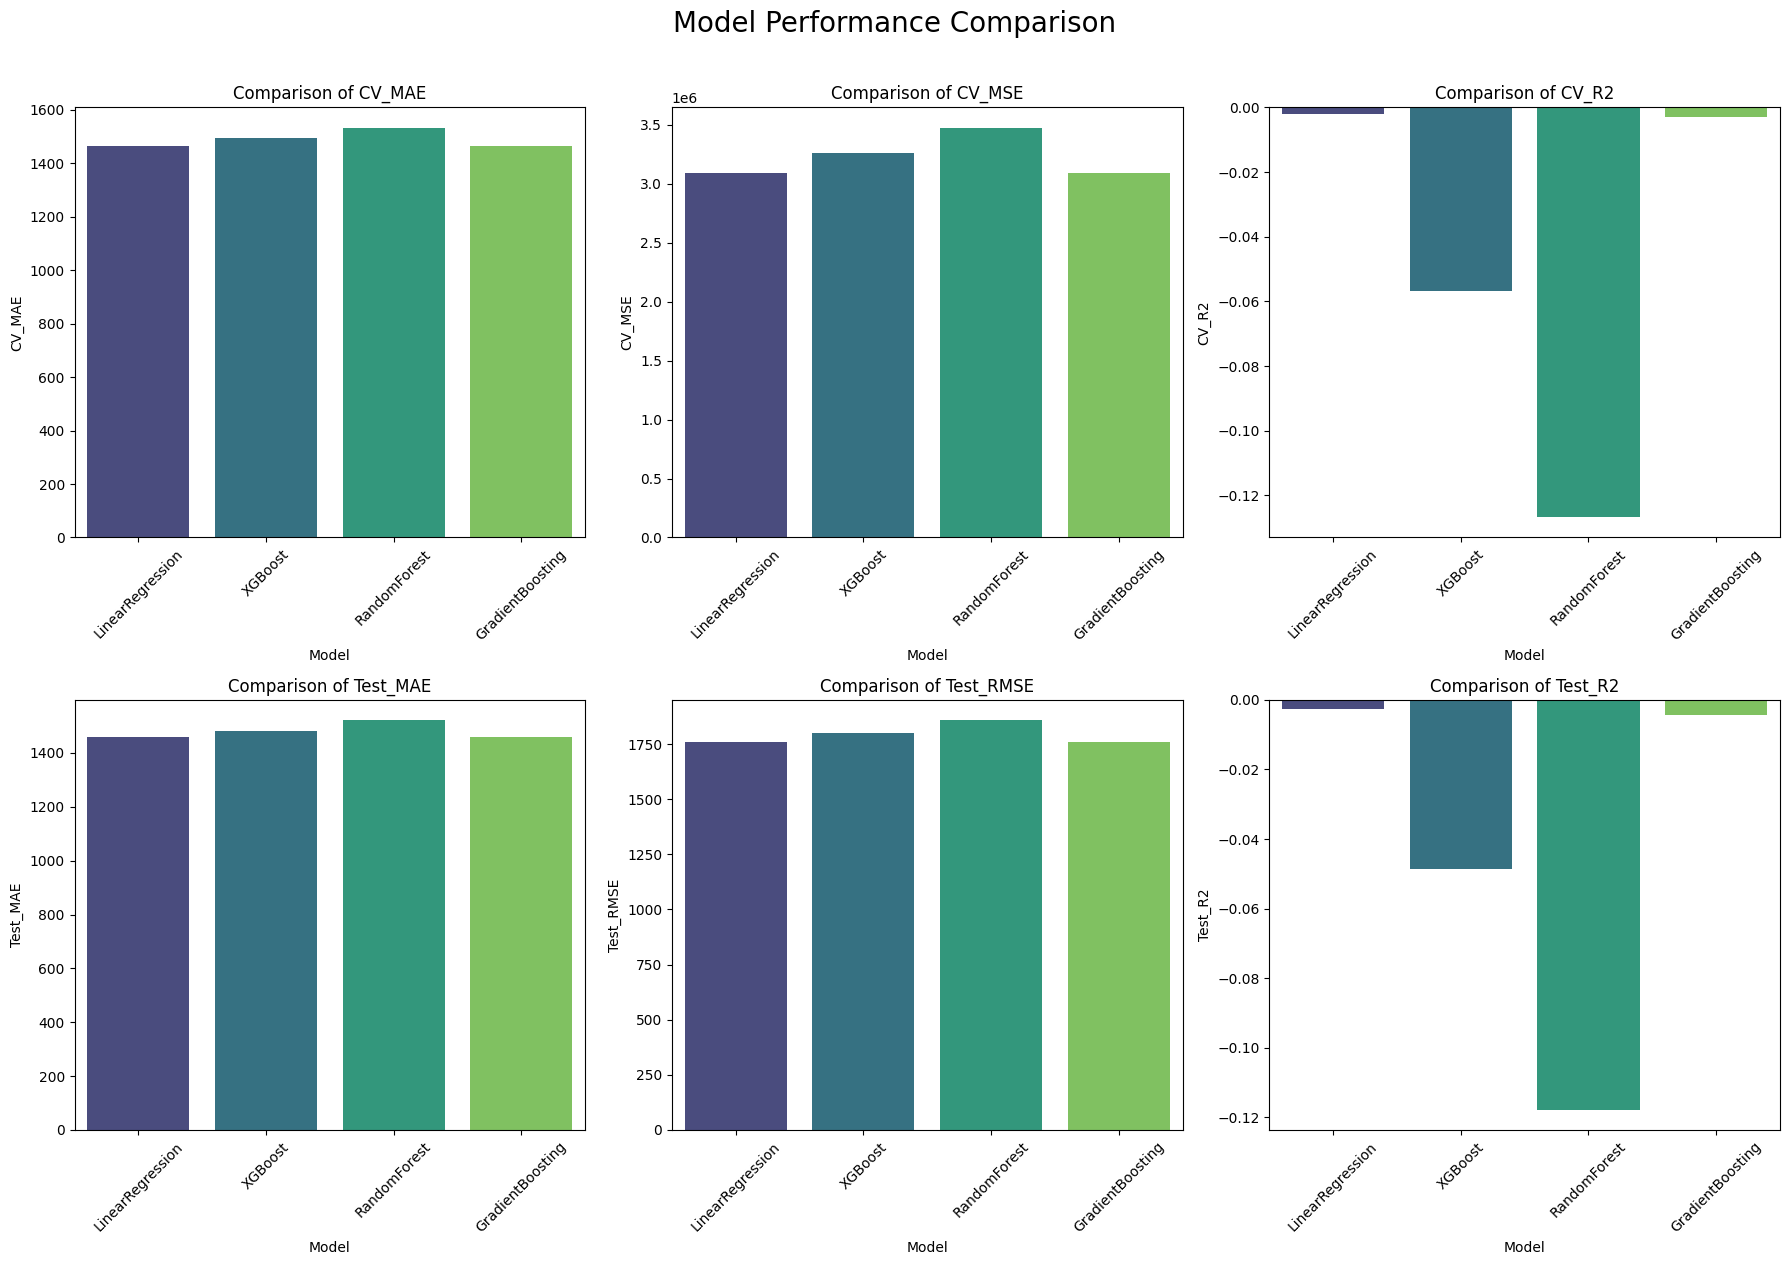

In [77]:
# Build and compare models
# Define model types to compare
models_to_compare = ['LinearRegression', 'XGBoost', 'RandomForest', 'GradientBoosting']

performance = build_and_compare_models(
        df=train_data,
        numerical_cols=numerical_cols,
        categorical_cols=categorical_cols,
        target='TotalCharges',
        test_size=0.2,
        random_state=42,
        n_splits=5,
        model_types=models_to_compare
)